In [3]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/human-stress-prediction/Stress.csv


In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from wordcloud import WordCloud
import matplotlib.pyplot as plt



# **Importing data**

In [5]:
stress_data_path = '../input/human-stress-prediction/Stress.csv'
stress_data = pd.read_csv(stress_data_path)
stress_data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [6]:
longest_post = max(stress_data.text, key=len)
len(longest_post.split()) #nr of words in the longest post

292

In [7]:
post_lengths = stress_data.text.apply(len) #lengths of all posts

post_lengths.mean() #avg length

posts = stress_data['text'].tolist()  # extract the 'posts' column as a list
labels = stress_data['label'].tolist()  # extract the 'labels' column as a list

# combine the two lists into a list of tuples
data = list(zip(posts, labels))


In [10]:
data[0][1]

1

# **Text Preprocessing**

In [7]:

#removing special characters 
#def remove_spec(text):
 #   return re.sub(r'[^a-zA-Z0-9\s]', '', text)

#clean_posts = list(map(remove_spec, stress_data.text))


In [8]:
import spacy
nlp = spacy.load("en_core_web_lg")

def preprocess_and_vectorize(post):
    doc = nlp(post) #fit the spacy model
    
    clean_tokens = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue #do not include punctuation chars and stopwords
        clean_tokens.append(token.lemma_)
    
    return clean_tokens


In [12]:
data[0]

('He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.',
 1)

In [9]:
tokenized_data = []
label_data = []
for post,label in data: 
    tokenized_post = preprocess_and_vectorize(post)
    if tokenized_post:
        tokenized_data.append(tokenized_post)
        label_data.append(label)


# A sprinkle of Data Visualization

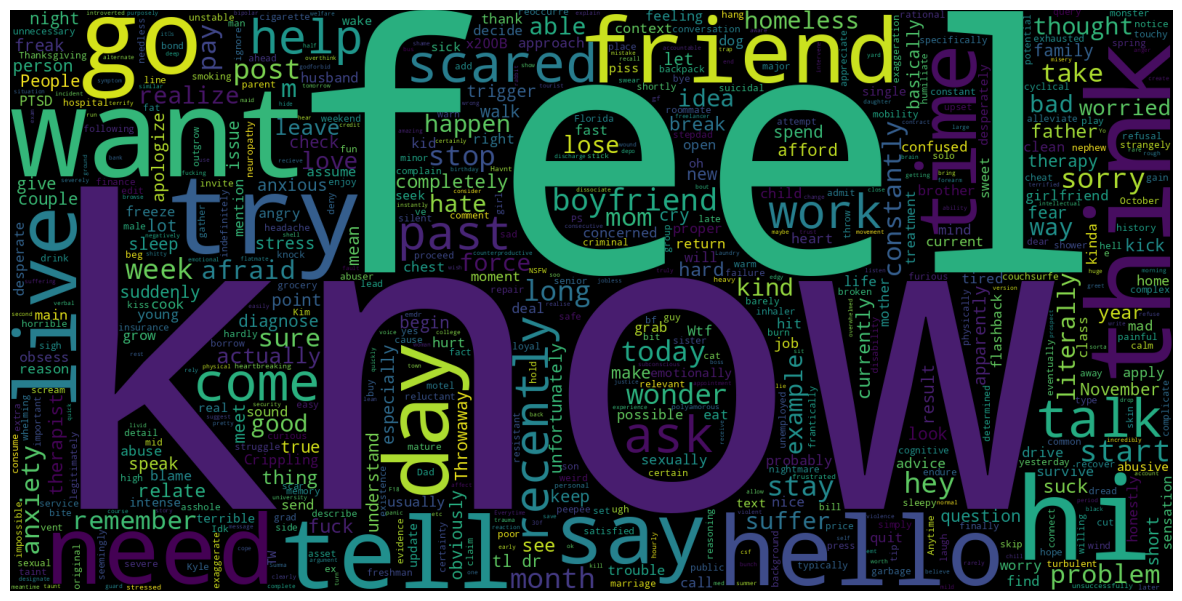

In [61]:
# extract input texts with label 1
input_texts = [data[0] for data, label in zip(tokenized_data, label_data) if label == 1]  #traverse the list as list of tuples 

# generate word cloud
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(input_texts)) #join strings into one 

# plot word cloud
plt.figure(figsize=(15, 15)) 
plt.imshow(wordcloud)
plt.axis('off')  # Remove axis
plt.show()



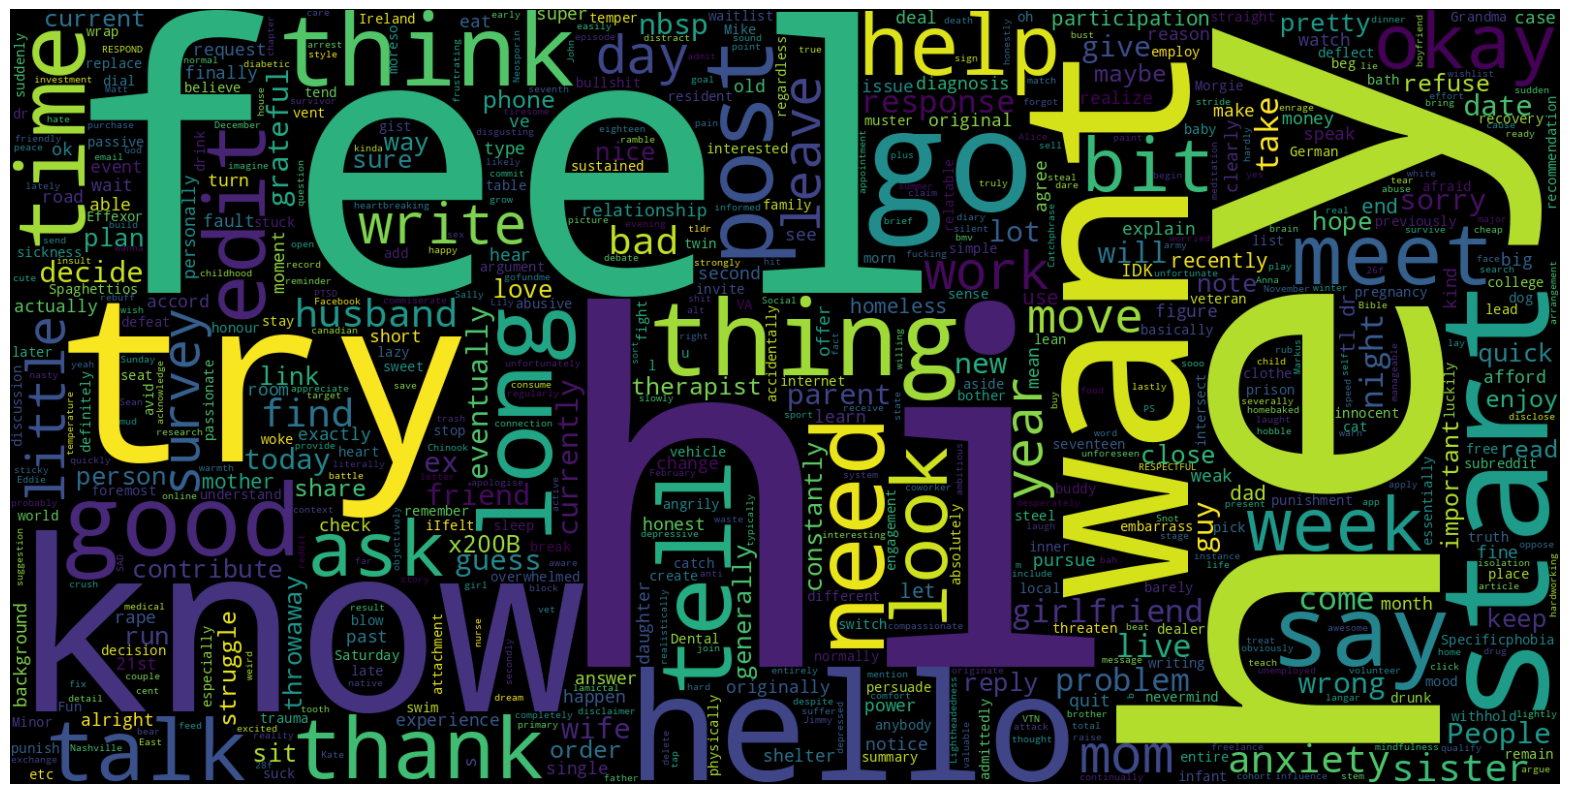

In [12]:
# extract input texts with label 0
input_texts = [data[0] for data, label in zip(tokenized_data, label_data) if label == 0]

# generate word cloud
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(input_texts))

# plot word cloud
plt.figure(figsize=(15, 15)) 
plt.imshow(wordcloud)
plt.axis('off')  # Remove axis
plt.show()


In [10]:
print(tokenized_data[0])
print(label_data[0])


['say', 'feel', 'way', 'suggete', 'rest', 'TRIGGER', 'AHEAD', "YOUI'RE", 'HYPOCONDRIAC', 'like', 'decide', 'look', 'feeling', 'doom', 'hope', 'maybe', 'getting', 'suck', 'rabbit', 'hole', 'ludicrous', 'conspiracy', 'stupid', 'psychic', 'test', 'new', 'age', 'b.s', 'laugh', 'road', 'end', 'read', 'sense', 'doom', 'indicative', 'health', 'ailment', 'prone', 'doom', 'gloom', "f'n", 'worried', 'heart', 'happen', 'physical', '48', 'hour']
1


# **Splitting Data**

In [11]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tokenized_data, 
    label_data, 
    train_size=0.8, 
    random_state=4
)



In [15]:
##X = clean_posts #attributes according to which we classify
#y = stress_data.label #class
# Convert X and y to NumPy arrays

# Initialize the stratified k-fold cross-validation object
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
#split_data = skf.split(X, y)

Vectorizing train data

# **Bag of Words**

# create the transform
tf_vectorizer=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,1))

# tokenize and build vocab
bow_train = tf_vectorizer.fit_transform(X_train)
# encode document
bow_test = tf_vectorizer.transform(X_test)
# summarize
#print(sorted(vectorizer.vocabulary_))
print('BOW train: ',bow_train.shape)
print('BOW test: ',bow_test.shape)

print(len(vectorizer.idf_))

# summarize encoded vector
print(vectorized_posts[0].shape)
print(vectorized_posts[0].toarray())


In [16]:
#print(len(vectorized_posts))
#print(len(stress_data))


# **Bag of N-Grams**

# create the transform
tf_vectorizer2 = TfidfVectorizer(analyzer='word', ngram_range=(7, 7)) #instead of separate words treat them as 7-grams, groups of len 7
# tokenize and build vocab
bon_train = tf_vectorizer2.fit_transform(X_train)

# encode document
bon_test = tf_vectorizer2.transform(X_test)
# summarize
#print(sorted(vectorizer.vocabulary_))
print('BON train: ',bow_train.shape)
print('BON test: ',bow_test.shape)



# **Generating embeddings**

In [ ]:
#vectorized_w2v = [gensim.utils.simple_preprocess(text) for text in clean_posts]
#len(vectorized_w2v)

wv = api.load("glove-twitter-25")


[===============================-------------------] 63.9% 67.0/104.8MB downloaded

In [20]:
wv.get_mean_vector(X_train[2])


array([-0.07963082,  0.02786993, -0.1118979 ,  0.07432982,  0.06536698,
        0.00142367,  0.09981715, -0.21375556,  0.06222064,  0.04254569,
        0.02311464,  0.09475099, -0.5490071 ,  0.01281391,  0.07900295,
        0.06116072,  0.04513504,  0.00119624,  0.04749446, -0.08894351,
       -0.07666157,  0.10886507,  0.12574716, -0.00554666, -0.09551053],
      dtype=float32)

In [53]:
len(wv.get_vector(X_train[2][0]))

25

In [14]:
wv_train_data = []
for tokenized_post in X_train:
    if tokenized_post:  #some may be empty bcs of stopword removal
        wv_train_data.append(wv.get_mean_vector(tokenized_post)) #get mean vector embedding for every post
wv_train_data[2]

array([-0.07963082,  0.02786993, -0.1118979 ,  0.07432982,  0.06536698,
        0.00142367,  0.09981715, -0.21375556,  0.06222064,  0.04254569,
        0.02311464,  0.09475099, -0.5490071 ,  0.01281391,  0.07900295,
        0.06116072,  0.04513504,  0.00119624,  0.04749446, -0.08894351,
       -0.07666157,  0.10886507,  0.12574716, -0.00554666, -0.09551053],
      dtype=float32)

In [18]:
len(wv_train_data[0]) #vector size for each post 

25

# **Naive Bayes**

* word2vec 0.6948853615520282


In [62]:
gnb = GaussianNB()
gnb.fit(wv_train_data, y_train)


GaussianNB()

In [63]:
wv_test_data = []
for tokenized_post in X_test:
    if tokenized_post:  #some may be empty bcs of stopword removal
        wv_test_data.append(wv.get_mean_vector(tokenized_post)) #get mean vector embedding for every post
prediction = gnb.predict(wv_test_data)
gnb_score=accuracy_score(y_test,prediction)
print("gnb_score :",gnb_score)

gnb_score : 0.6948853615520282


# LSTM :)

In [29]:
len(wv_train_data[465])

25

In [47]:
vocab_size = len(wv.key_to_index)
input_length = len(wv_train_data[0])
embedding_length = 10

In [49]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding,Dropout, Input, BatchNormalization, Bidirectional
import numpy as np
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
cp = ModelCheckpoint('model/', save_best_only = True)

# Assuming you have tokenized sequences X_train and X_test and corresponding labels y_train, y_test
# Also, assuming you have word embeddings wv

# Define LSTM model
model = Sequential()
#model.add(Input(shape=(len(wv_train_data[0]), 1)))
model.add(Embedding(vocab_size, embedding_length, input_length = input_length))
model.add(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.25))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True, dropout=0.6, recurrent_dropout=0.25))
model.add(BatchNormalization())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# compile model
model.compile(optimizer=Adam(lr=0.008), loss='binary_crossentropy', metrics=['accuracy'])

y_train2 = np.asarray(y_train).astype('float32').reshape((-1,1))

# train model
model.fit(np.array(wv_train_data), y_train2, epochs=30, batch_size=32)
          
wv_test_data = []
for tokenized_post in X_test:
    if tokenized_post:  #some may be empty bcs of stopword removal
        wv_test_data.append(wv.get_mean_vector(tokenized_post)) #get mean vector embedding for every post

# evaluate model
y_test2 = np.asarray(y_test).astype('float32').reshape((-1,1))

loss, accuracy = model.evaluate(np.array(wv_test_data), y_test2)
print("Test Accuracy:", accuracy)


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 10)            11935140  
                                                                 
 lstm_35 (LSTM)              (None, 25, 128)           71168     
                                                                 
 batch_normalization_2 (Bat  (None, 25, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_36 (LSTM)              (None, 25, 128)           131584    
                                                                 
 batch_normalization_3 (Bat  (None, 25, 128)           512       
 chNormalization)                                                
                                                                 
 dense_35 (Dense)            (None, 25, 64)          

KeyboardInterrupt: 

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Initialize variables to store the total accuracy across all folds
total_accuracy = 0.0

# Iterate over the folds
for train_index, test_index in split_data:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    gnb.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = gnb.predict(X_test)

    # Calculate accuracy for this fold
    fold_accuracy = accuracy_score(y_test, y_pred)

    # Accumulate accuracy for all folds
    total_accuracy += fold_accuracy

    # Print accuracy for this fold
    print("Accuracy for this fold:", fold_accuracy)

# Calculate average accuracy across all folds
average_accuracy = total_accuracy / skf.n_splits

print("Average Accuracy:", average_accuracy)



# initialize the naive bayes classifier
gnb1 = GaussianNB()
gnb2 = GaussianNB()

#fitting the nb for bag of words
gnb_bow=gnb1.fit(bow_train.toarray(), y_train)
print(gnb_bow)
#fitting the nb for tfidf features
gnb_bon=gnb2.fit(bon_train.toarray(), y_train)
print(gnb_bon)


#Predicting the model for bag of words
gnb_bow_predict = gnb_bow.predict(bow_test.toarray())

#Predicting the model for bag of ngrams
gnb_bon_predict = gnb_bon.predict(bon_test.toarray())


#Accuracy score for bag of words
gnb_bow_score=accuracy_score(y_test,gnb_bow_predict)
print("gnb_bow_score :",gnb_bow_score)
#Accuracy score for tfidf features
gnb_bon_score=accuracy_score(y_test,gnb_bon_predict)
print("gnb_bon_score :",gnb_bon_score)